### Import Package

In [75]:
import io
import json
import openai
import random
import zipfile
import numpy as np
import pandas as pd

from PIL import Image
from numba import jit
from tqdm import tqdm

from utils.system import *
from class_prompt.prompt_gpt import PromptGPT
from class_model.dlip_prod import DLIPProd

### Retrieve Image Files List from Kaggle Zip

In [2]:
# Open the ZIP file
with zipfile.ZipFile(get_data() / 'archive.zip', 'r') as zip_ref:
    # Filter for files in the specific folder
    image_files = [f for f in zip_ref.namelist() if f.startswith('various_tagged_images/') and f.endswith(('.png', '.jpg', '.jpeg'))]

# Display Length
print(f"Length of image_files: {len(image_files)}")

Length of image_files: 758935


### Retrieve 5000 Images Files Randomly Sampled with More than 5 Tags

In [3]:
# Count tages (every image follows the following convention: id-tag1_tag2_..._tagN.jpg)
def count_tags(filename):
    name_part = filename.split('/')[-1].split('.')[0]
    return len(name_part.split('_')) - 1

# Retrieve Image Files that have more 5 Tags
image_files_5_tags = [file for file in image_files if count_tags(file) >= 5]

# Display length
print(f"Length of image_files_5_tags: {len(image_files_5_tags)}")

selected_files = selected_files = random.sample(image_files_5_tags, min(5000, len(image_files_5_tags)))

# Display length
print(f"Length of selected_files: {len(selected_files)}")

# Display Files
print("-"*60)
for i, file in enumerate(image_files):
    print(file)
    if i == 4:
        break

Length of image_files_5_tags: 7989
Length of selected_files: 5000
------------------------------------------------------------
various_tagged_images/00018990-funny_love_meme.jpg
various_tagged_images/0002fd38-love_photooftheday_instalike.jpg
various_tagged_images/00035616-inlove_love.jpg
various_tagged_images/0003e91a-clouds_hiking_trees.jpg
various_tagged_images/0004195c-artist_photo.jpg


In [33]:
# Export selected files
selected_files_pd = pd.DataFrame(selected_files, columns=['folder'])
selected_files_pd.to_csv(get_data() / 'selected_files.csv', index=False)

### Read in an Image

In [64]:
# Read in selected files
selected_files = pd.read_csv(get_data() / 'selected_files.csv')
selected_files = selected_files['folder'].tolist()

Image File: various_tagged_images/6ae1dd63-vacation_happy_wanderlust_instagood_sea_insta_summer_instatravel_photooftheday_boy.jpg



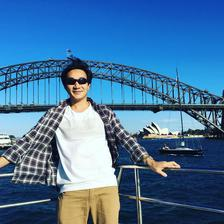

In [4]:
# Open the ZIP file
with zipfile.ZipFile(get_data() / 'archive.zip', 'r') as zip_ref:
    # Loop through the selected files
    for image_file in selected_files:
        with zip_ref.open(image_file) as file:
            # Read the image file's content
            image_data = file.read()
            # Process the image
            image = Image.open(io.BytesIO(image_data))
        break
print(f"Image File: {image_file}\n")
image

### Get ID and Tags

In [78]:
def get_id_and_tags(filename):
    # Extract the part of the filename without the directory and extension
    name_part = filename.split('/')[-1]
    name_without_extension = name_part.split('.')[0]
    # Split on the first '-' to separate the ID from the tags
    parts = name_without_extension.split('-', 1)
    image_id = parts[0] if parts else ""
    tags_part = parts[1] if len(parts) > 1 else ""
    # Split the tags part by '_' to get individual tags
    tags = tags_part.split('_') if tags_part else []
    # Return 5 tags only
    tags = tags[:5]
    return image_id, tags

In [ ]:
# Collect Tags and ID
collect_id = []
collect_tags = []
for file in selected_files:
    image_id, tags = get_id_and_tags(file)
    collect_id.append(image_id)
    collect_tags.append(tags)

In [ ]:
# Export Dataframe
id_tags_pd = pd.DataFrame(collect_tags, index=collect_id, columns=['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5'])
id_tags_pd.index.names = ['image_id']
id_tags_pd.to_csv(get_data() / 'id_and_tags.csv')

### Create Query (Single)

In [15]:
def create_query(tags):
    message = f"You are a clueless user of a digital asset management software that helps you find assets on your " \
              f"computer by searching for content using AI rather that metadata. Generate ONE short search query " \
              f"using only the noun of the image you're looking for with adjectives that describe it in plain " \
              f"english that you could use to find an image file with the given tags: {tags}. " \
              f"Only use the information from the tags to generate the prompt." \
              f"Do not search for anything but the information in tags list provided" \
              f"Do not speak to the quality of the image, only the tags. Put some randomness in the " \
              f"structure of your query, in lowercase with no punctuation. They should not all sound exactly the same."
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": message},
        ]
    )

    query = response.choices[0].message.content.translate(str.maketrans('', '', '."'))
    return query

# Example
str_tags = str(tags)
query = create_query(str_tags)
print(f"Query: {query}")

Query: fluffy playful animals


### Create Query (Parallelized)

In [3]:
# Convert tags to strings
id_and_tags = pd.read_csv(get_data() / 'id_and_tags.csv')
id_and_tags = id_and_tags.drop('image_id', axis=1)
str_tags = []
for i, row in id_and_tags.iterrows():
    str_tags.append(str(row[id_and_tags.columns].tolist()))

In [7]:
# Retrieve querys
items = str_tags
batch_size = 5
prompt_gpt = PromptGPT(items=items, batch_size=batch_size)
querys = prompt_gpt.get_gpt_topic()

2024-04-06 21:45:33,030	INFO worker.py:1724 -- Started a local Ray instance.
Processing batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:46<00:00,  2.45s/it]


In [10]:
# Export Dataframe
id_and_tags = pd.read_csv(get_data() / 'id_and_tags.csv')
querys_pd = pd.DataFrame(querys, index=id_and_tags['image_id'], columns=['query'])
querys_pd.index.names = ['image_id']
querys_pd.to_csv(get_data() / 'querys.csv')

### Filter Querys

In [33]:
# Read in querys
querys = pd.read_csv(get_data() / 'querys.csv')

In [34]:
def word_count(texts):
    counts = np.zeros(len(texts), dtype=np.int32)
    for i, text in enumerate(texts):
        counts[i] = len(text.split())
    return counts

# Get word_count and filter
querys['word_count'] = fast_word_count(querys['query'].values)
bad_query = querys.loc[querys.word_count > 10].image_id.unique()
querys = querys.loc[querys.word_count <= 10]

In [41]:
# Export Bad Query
bad_query_pd = pd.DataFrame(bad_query, columns=['bad_query'])
bad_query_pd.to_csv(get_data() / 'bad_querys.csv', index=False)

In [65]:
# Filter selected files
bad_query_pd = pd.read_csv(get_data() / 'bad_querys.csv')
bad_queries = set(bad_query_pd['bad_query'])
selected_files = [file for file in selected_files if not any(bad_query in file for bad_query in bad_queries)]

### Embedding Retrieval

In [44]:
# Batch Size
batch_size = 16
# Load Model
dlip_retrieval = DLIPProd(name='retrieval', weight=get_data() / 'dlip_retrieval_flickr.pth', device='cuda')

In [93]:
# Open the ZIP file
with zipfile.ZipFile(get_data() / 'archive.zip', 'r') as zip_ref:
    # Create batches
    files_batches = [selected_files[i:i + batch_size] for i in range(0, len(selected_files), batch_size)]
    query_batches = [querys['query'].tolist()[i:i + batch_size] for i in range(0, len(querys), batch_size)]

    # Initialize arrays for concatenation
    concat_image_feats = np.empty((0, 256), dtype=np.float32)
    concat_tag_feats = np.empty((0, 5, 256), dtype=np.float32)
    concat_query_feats = np.empty((0, 256), dtype=np.float32)
     
    for file_batch, query_batch in tqdm(zip(files_batches, query_batches), total=len(files_batches)):
        # Read images in and get tags
        image_batch = []
        tags_batch = []
        for image_file in file_batch:
            with zip_ref.open(image_file) as file:
                image_data = file.read()
                image = Image.open(io.BytesIO(image_data))
            image_batch.append(image)
            
            # Get Id and 5 Tags
            image_id, tags = get_id_and_tags(image_file)
            tags_batch.extend(tags)

        # Embedding Retrieval
        image_feat = dlip_retrieval.get_image_feat(image_batch).detach().cpu().numpy()
        tag_feat = dlip_retrieval.get_text_feat(tags_batch).detach().cpu().numpy()
        tag_feat = tag_feat.reshape((-1, 5, 256))
        query_feat = dlip_retrieval.get_text_feat(query_batch).detach().cpu().numpy()

        # Concatenate features along the x-axis
        concat_image_feats = np.concatenate((concat_image_feats, image_feat), axis=0)
        concat_tag_feats = np.concatenate((concat_tag_feats, tag_feat), axis=0)
        concat_query_feats = np.concatenate((concat_query_feats, query_feat), axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [01:18<00:00,  3.82it/s]


In [94]:
# Export Numpy Arrays
np.save(get_data() / "image_feats.npy", concat_image_feats)
np.save(get_data() / "tag_feats.npy", concat_tag_feats)
np.save(get_data() / "query_feats.npy", concat_query_feats)